In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [2]:
import os 
os.getcwd()#Hibaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

'C:\\Users\\pc\\Desktop\\hft\\trading-technical-indicators-a-0\\tti\\indicators'

In [4]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [5]:
data=pd.read_csv("MASI.csv",parse_dates=True, index_col=0)

In [6]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,0,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,0,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,0,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,0,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,0,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,0,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,0,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,0,MAD


In [7]:
df=data["Close"].loc["2018-01-02":]
high=data["High"].loc["2018-01-02":]
low=data["Low"].loc["2018-01-02":]


In [8]:
data["Volume"]=data["Close"]

In [23]:
data

,open,high,low,close,volume,currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,12420.15,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,12509.58,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,12463.08,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,12537.75,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,12479.42,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,12640.22,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,12721.38,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,12751.45,MAD


## Fonction

In [9]:
premier=0 

In [10]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [11]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

## **TEST RSI**

In [12]:
from _relative_strength_index import RelativeStrengthIndex

In [13]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,12420.15,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,12509.58,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,12463.08,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,12537.75,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,12479.42,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,12640.22,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,12721.38,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,12751.45,MAD


In [14]:
rsi=RelativeStrengthIndex(data)

In [20]:
rsi

In [21]:
rsi._calculateTi(period=16)["rsi"]

Date
2018-01-02        NaN
2018-01-03        NaN
2018-01-04        NaN
2018-01-05        NaN
2018-01-08        NaN
               ...   
2022-03-28    38.7875
2022-03-29    42.0489
2022-03-30    43.2439
2022-03-31    45.8828
2022-04-01    46.8869
Name: rsi, Length: 1056, dtype: float64

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

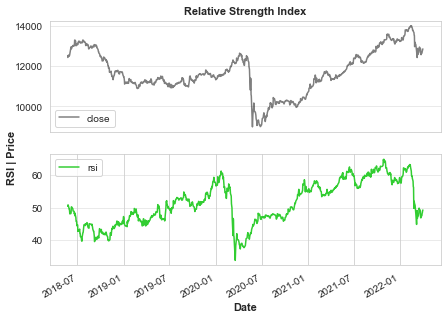

In [25]:
rsi.getTiGraph()

In [26]:
rsi.getTiSignal()

('hold', 0)

In [37]:
rsi.getTiValue()

[49.3097]

In [41]:
data=df

In [47]:
df=pd.DataFrame(df)


Simulation Data:
            signal open_trading_action stock_value exposure portfolio_value  \
Date                                                                         
2018-01-02   hold                none    12420.15      0.0             0.0   
2018-01-03   hold                none    12509.58      0.0             0.0   
2018-01-04   hold                none    12463.08      0.0             0.0   
2018-01-05   hold                none    12537.75      0.0             0.0   
2018-01-08   hold                none    12479.42      0.0             0.0   
...           ...                 ...         ...      ...             ...   
2022-03-28   hold                none    12640.22      0.0             0.0   
2022-03-29   hold                none    12721.38      0.0             0.0   
2022-03-30   hold                none    12751.45      0.0             0.0   
2022-03-31   hold                none    12818.11      0.0             0.0   
2022-04-01   hold                none    1284

'\nsimulation_data=pd.DataFrame(simulation_data)\nsimulation_statistics=pd.DataFrame(simulation_statistics)\n'

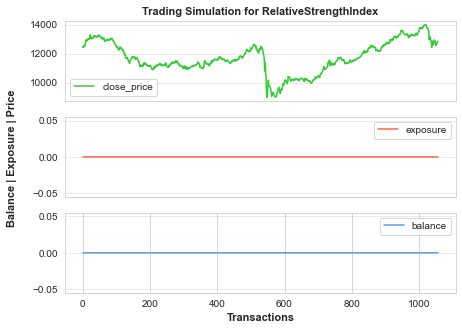

In [50]:
simulation_data, simulation_statistics, simulation_graph = \
rsi.getTiSimulation(close_values=df[['Close']], max_exposure=None,short_exposure_factor=1.5)
print('\nSimulation Data:\n', simulation_data)
print('\nSimulation Statistics:\n', simulation_statistics)
"""
simulation_data=pd.DataFrame(simulation_data)
simulation_statistics=pd.DataFrame(simulation_statistics)
"""

In [57]:
simulation_data=pd.DataFrame(simulation_data,index=df.index)
simulation_statistics=pd.DataFrame(simulation_statistics,index=df.index)
simulation_statistics

,number_of_trading_days,number_of_buy_signals,number_of_ignored_buy_signals,number_of_sell_signals,number_of_ignored_sell_signals,last_stock_value,last_exposure,last_open_long_positions,last_open_short_positions,last_portfolio_value,last_earnings,final_balance
Date,,,,,,,,,,,,
2018-01-02,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
2018-01-03,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
2018-01-04,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
2018-01-05,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
2018-01-08,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
2022-03-29,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0
2022-03-30,1056,0,0,0,0,12843.52,0.0,0,0,0.0,0.0,0.0


In [21]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [18]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

## RSI

In [19]:
def  obj_rsi(period):
    global haut
    global bas
    period=int(period[0])
    signal=pd.DataFrame(index=df.index)
    rs=rsi._calculateTi(period)["rsi"]
#rs=at.rsi(df,n)["RSI"]
    signal["compa_achat"]=np.nan
    signal["compa_vente"]=np.nan
    signal["compa_achat"][period:]=np.where(rs[period:] > bas,1,0)
    signal["signal_achat"]=signal["compa_achat"].diff()
    signal["compa_vente"][period:]=np.where(rs[period:] < haut,4,2)
    signal["signal_vente"]=signal["compa_vente"].diff()
    sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
    sig=adjustsignal(sig)
    sig=pd.Series(sig, index=df.index)
    cours=df*(1+taux*sig)
    pmval=pmv(cours,sig)
    return pmval.max(),

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


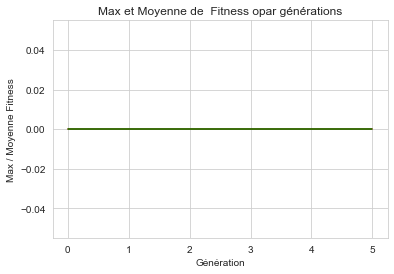

In [22]:
haut,bas=0.7,0.3
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


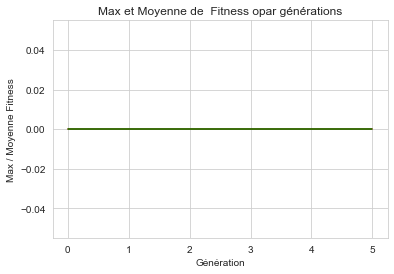

In [33]:
haut,bas=0.75,0.25
GeneticAlgo(1,obj_rsi,5,13,30)


gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


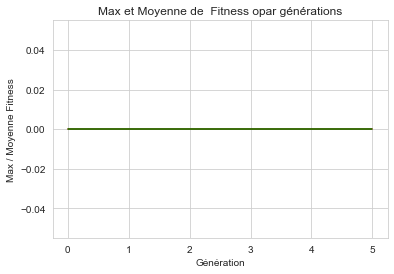

In [34]:
haut,bas=0.8,0.20
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
6  	35    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


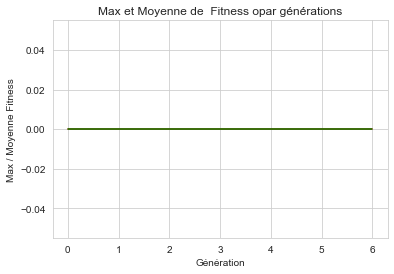

In [35]:
haut,bas=0.85,0.15
GeneticAlgo(1,obj_rsi,6,13,30)

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
6  	35    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


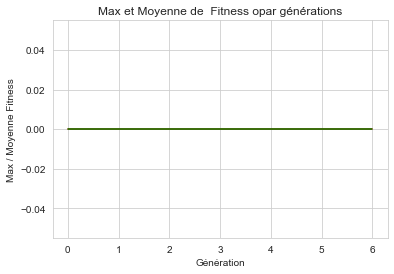

In [24]:
haut,bas=0.9,0.1
GeneticAlgo(1,obj_rsi,6,13,30)